# Spatio-temporal Transcriptomics

Toy dataset from López-Lopera et al. (2019)

- Data download: https://github.com/anfelopera/PhysicallyGPDrosophila

In [1]:
import numpy as np
import torch

from torch.nn import Parameter
from gpytorch.constraints import Interval
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from lafomo.utilities.torch import get_image
from lafomo.datasets import DrosophilaSpatialTranscriptomics
from lafomo.models import MultiOutputGP, PartialLFM
from lafomo.models.pdes import ReactionDiffusion
from lafomo.datasets import ToySpatialTranscriptomics, P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import discretise
from lafomo.utilities.fenics import interval_mesh
from lafomo.plot import Plotter, plot_before_after


In [7]:
def plot_spatiotemporal_data(images):
    """Data"""
    fig = plt.figure()
    grid = ImageGrid(fig, 111,  # similar to subplot(144)
                     nrows_ncols=(2, 3),
                     axes_pad=(0.45, 0.15),
                     label_mode="1",
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="each",
                     cbar_size="7%",
                     cbar_pad="2%",
                     )

    for image, ax, cax in zip(images, grid, grid.cbar_axes):
        print(image.shape)
        im = ax.imshow(image, extent=[0, 1, 0, 1], origin='lower')#,  vmin=vlim[0], vmax=vlim[1])
        ax.axis('off')
        cb = plt.colorbar(im, cax=cax)
        cb.set_ticks(np.linspace(image.min(), int(image.max()/100)*100, 6))

    # This affects all axes because we set share_all = True.
    grid.axes_llc.set_xticks([-2, 0, 2])
    grid.axes_llc.set_yticks([-2, 0, 2])

(64, 8)
(57, 8)
(64, 8)
(64, 8)
(57, 8)
(64, 8)


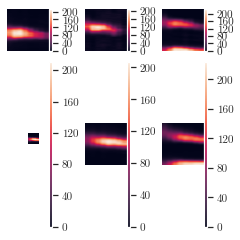

In [9]:
kr_dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')
kni_dataset = DrosophilaSpatialTranscriptomics(gene='kni', data_dir='../../../data')
gt_dataset = DrosophilaSpatialTranscriptomics(gene='gt', data_dir='../../../data')

drosophila = True

if drosophila:
    dataset = DrosophilaSpatialTranscriptomics(gene='kr', data_dir='../../../data')

    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 10
    images = [get_image(dataset.orig_data, i)
          for i in range(2, 4)
          for dataset in [kr_dataset, kni_dataset, gt_dataset]
          ]

    plot_spatiotemporal_data(images)
    num_inducing = 450

else:
    dataset = ToySpatialTranscriptomics(data_dir='../../../data/')
    data = next(iter(dataset))
    tx, y_target = data
    lengthscale = 0.2
    num_inducing = 1000


We can either create a simple unit interval mesh

In [4]:
from dolfin import *

mesh = UnitIntervalMesh(40)

Alternatively, if our spatial data is not uniformly spaced, we can define a custom mesh as follows.

In [5]:
# We calculate a mesh that contains all possible spatial locations in the dataset

spatial = np.unique(tx[1, :])
mesh = interval_mesh(spatial)

# The mesh coordinates should match up to the data:
print('Matching:', all(spatial == mesh.coordinates().reshape(-1)))
#plot(mesh)
print(type(spatial))

Matching: True
<class 'numpy.ndarray'>


Set up GP model

In [6]:
ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
t_diff = ts[-1]-ts[0]
x_diff = xs[-1]-xs[0]
extent = [ts[0], ts[-1], xs[0], xs[-1]]
print(extent)

inducing_points = torch.stack([
    ts[0] + t_diff * torch.rand((1, num_inducing)),
    xs[0] + x_diff * torch.rand((1, num_inducing))
], dim=2)
print(inducing_points.shape)
gp_kwargs = dict(use_ard=True,
                 use_scale=False,
                 # lengthscale_constraint=Interval(0.1, 0.3),
                 learn_inducing_locations=False,
                 initial_lengthscale=lengthscale)
gp_model = MultiOutputGP(inducing_points, 1, **gp_kwargs)
gp_model.double();

[53.925, 97.675, 25.5, 88.5]
torch.Size([1, 450, 2])


Set up PDE

In [7]:
t_range = (ts[0], ts[-1])
print(t_range)
time_steps = dataset.num_discretised

fenics_model = ReactionDiffusion(t_range, time_steps, mesh)

config = VariationalConfiguration(
    initial_conditions=False,
    num_samples=25
)

sensitivity = Parameter(torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
decay = Parameter(0.1*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
diffusion = Parameter(0.01*torch.ones((1, 1), dtype=torch.float64), requires_grad=True)
fenics_params = [sensitivity, decay, diffusion]

lfm = PartialLFM(1, gp_model, fenics_model, fenics_params, config)

# print(list(lfm.named_parameters()))

(53.925, 97.675)


In [8]:
from lafomo.trainer import VariationalTrainer
from lafomo.utilities.torch import is_cuda



optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
trainer = PDETrainer(lfm, optimizer, dataset)

torch.Size([2, 512])
t_sorted, dp [53.925 60.175 66.425 72.675 78.925 85.175 91.425 97.675] 6.25
1.0
t_sorted, dp [25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5
 39.5 40.5 41.5 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5
 53.5 54.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5
 81.5 82.5 83.5 84.5 85.5 86.5 87.5 88.5] 1.0


/Users/jacob/miniconda3/envs/wishart/lib/python3.7/site-packages/torch/optim/adam.py:48: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


Now let's see some samples from the GP and corresponding LFM output

8 64 7
yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])
yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])


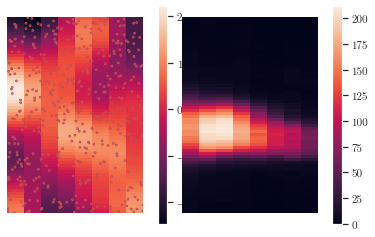

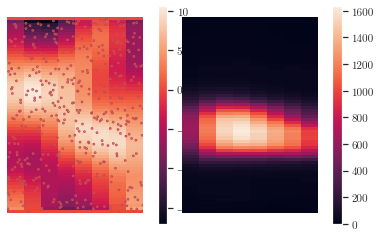

In [9]:
num_t = trainer.tx[0, :].unique().shape[0]
num_x = trainer.tx[1, :].unique().shape[0]
print(num_t, num_x, lfm.time_steps)

# gp_model.covar_module.lengthscale = 0.3*0.3 * 2
out = gp_model(tx.transpose(0, 1))

sample = out.sample(torch.Size([1])).permute(0, 2, 1)
real = torch.tensor(dataset.orig_data[trainer.t_sorted, 2]).unsqueeze(0)


plot_before_after(
    sample.squeeze().detach().view(num_t, num_x).transpose(0, 1),
    real.squeeze().view(num_t, num_x).transpose(0, 1),
    extent
)
sample = sample.repeat(lfm.config.num_samples, 1, 1)
real = real.repeat(lfm.config.num_samples, 1, 1)
sample = sample.view(lfm.config.num_samples, 1, num_t, num_x)
real = real.view(lfm.config.num_samples, 1, num_t, num_x)

out = lfm.solve_pde(sample)
real_out = lfm.solve_pde(real)

plot_before_after(
    out[0].detach().transpose(0, 1),
    real_out[0].detach().transpose(0, 1),
    extent
)

In [10]:
print(num_t)

8


In [11]:
# lfm = PartialLFM.load('test',
#                       gp_cls=MultiOutputGP,
#                       gp_args=[inducing_points, 1],
#                       gp_kwargs=gp_kwargs,
#                       lfm_args=[config, dataset])
#
# optimizer = torch.optim.Adam(lfm.parameters(), lr=0.07)
# trainer = PDETrainer(lfm, optimizer, dataset)

yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])
torch.Size([1, 512]) torch.Size([1, 512])
torch.Size([1, 512, 512])
tensor(94.7721, dtype=torch.float64, grad_fn=<MaxBackward1>) torch.Size([512, 1]) torch.Size([512, 1])
Epoch 001/001 - Loss: 1562.11 (1562.11 0.00) λ: [10.13999369  9.86000645] s: 0.9300000000217021 dif: 0.9300000000217021 dec: 0.9300000000217021


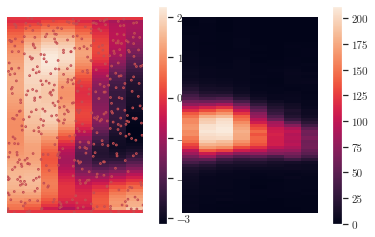

In [12]:
trainer.train(1)

In [13]:
print(list(lfm.named_parameters()))

[('fenics0', Parameter containing:
tensor([[0.9300]], dtype=torch.float64, requires_grad=True)), ('fenics1', Parameter containing:
tensor([[0.1700]], dtype=torch.float64, requires_grad=True)), ('fenics2', Parameter containing:
tensor([[0.0800]], dtype=torch.float64, requires_grad=True)), ('gp_model.variational_strategy.base_variational_strategy._variational_distribution.variational_mean', Parameter containing:
tensor([[ 0.1398,  0.1408,  0.1388,  0.1390,  0.1378,  0.1401,  0.1403,  0.1410,
          0.1401,  0.1382,  0.1404,  0.1383,  0.1414,  0.1397, -0.1399,  0.1400,
          0.1394,  0.1391,  0.1388,  0.1378,  0.1407,  0.1399,  0.1405, -0.1396,
         -0.1399,  0.1393,  0.1406, -0.1413, -0.1404,  0.1399, -0.1408, -0.1389,
         -0.1395,  0.1388,  0.1410,  0.1402, -0.1406,  0.1385, -0.1409, -0.1384,
          0.1399,  0.1396,  0.1417, -0.1414,  0.1409,  0.1404, -0.1419,  0.1390,
         -0.1393,  0.1386, -0.1403, -0.1414,  0.1393, -0.1415,  0.1371,  0.1396,
         -0.1405,  

In [14]:
lfm.save('test')

['[10.13999369  9.86000645]']
[[10.13999369  9.86000645]]


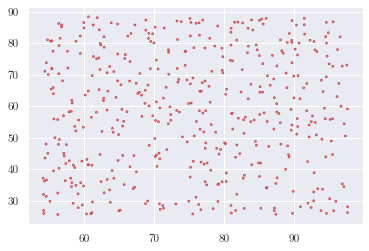

In [15]:
xy = lfm.inducing_points.detach()[0]
plt.scatter(xy[:, 0], xy[:, 1], facecolors='none', edgecolors='r', s=3)

kernel = lfm.gp_model.covar_module
print([str(l.detach().numpy()) for l in kernel.lengthscale[0]])
print(str(kernel.lengthscale[0].detach().numpy()))

In [16]:
data = next(iter(trainer.data_loader))
tx, y_target = data
tx = tx[0]


In [17]:
initial_value = None
print(tx.shape)
f_mean, f_var = lfm(tx, initial_value)
plt.imshow(f_mean.transpose(1, 2)[0].detach())
plt.scatter(tx[0], tx[1], c=output)

torch.Size([2, 512])
yprev u torch.Size([25, 64]) torch.Size([25, 1, 8, 64])
torch.Size([25, 8, 64])
torch.Size([1, 512]) torch.Size([1, 512])
torch.Size([1, 512, 512])


RuntimeError: BlockInterleavedLazyTensor.__getitem__ failed! Expected a final shape of size torch.Size([512]), got torch.Size([512, 512]). This is a bug with GPyTorch, or your custom LazyTensor.

In [ ]:
print(lfm.kernel.lengthscale, lfm.sensitivity, lfm.diffusion)
